## Importing libraries

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from neo4j import GraphDatabase
from node2vec import Node2Vec

%matplotlib inline

## Connect to the Database

In [2]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "OLIV00%%"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [6]:
graph = nx.Graph()

with driver.session() as session:
    # Récupérer les nœuds avec leur nom et type
    nodes_query = "MATCH (n) RETURN ID(n) AS id, n.name AS name, n.type AS type"
    nodes_result = session.run(nodes_query)

    # Parcourir les résultats et ajouter les nœuds au graphe
    for record in nodes_result:
        node_id = record["id"]
        node_name = record["name"]
        node_type = record["type"]
        if node_id is not None:
            graph.add_node(node_id, name=node_name, type=node_type)

    # Récupérer les relations
    relations_query = "MATCH ()-[r]->() RETURN ID(startNode(r)) AS source_id, ID(endNode(r)) AS target_id"
    relations_result = session.run(relations_query)

    # Ajouter les relations entre les nœuds
    for record in relations_result:
        source_node_id = record["source_id"]
        target_node_id = record["target_id"]
        if source_node_id is not None and target_node_id is not None:
            graph.add_edge(source_node_id, target_node_id)
            
            
# After creating the graph and adding nodes and edges as you described

machine_state_ids = [33, 34, 35, 36,37, 38, 39]
component_ids = [28, 29, 30]

#machine_state_ids = [20, 21, 22, 23, 24, 25, 26, 27]
#component_ids = [17, 18, 19]

## CN2D

In [7]:
def common_neighbors(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1))
    neighbors2 = set(graph.neighbors(node2))
    return neighbors1.intersection(neighbors2)

def resource_distribution_metric(graph, node1, node2, common_neighbors):
    max_degree = max(graph.degree[node1], graph.degree[node2])
    return sum(1 / max_degree for node in common_neighbors)

def link_prediction(graph, node_pairs, beta):
    predictions = {}
    for node_pair in node_pairs:
        node1, node2 = node_pair
        neighbors1 = set(graph.neighbors(node1))
        neighbors2 = set(graph.neighbors(node2))
        common_neighbors_set = neighbors1.intersection(neighbors2)

        resource_metric = 0
        for z in common_neighbors_set:
            resource_metric += 1 / max(len(neighbors1), len(neighbors2)) * len(set(graph.neighbors(z)))

        if (node1, node2) not in predictions:
            predictions[(node1, node2)] = len(common_neighbors_set) + beta * resource_metric
        else:
            predictions[(node1, node2)] += beta * resource_metric

    return predictions

## Splited Graph Plot

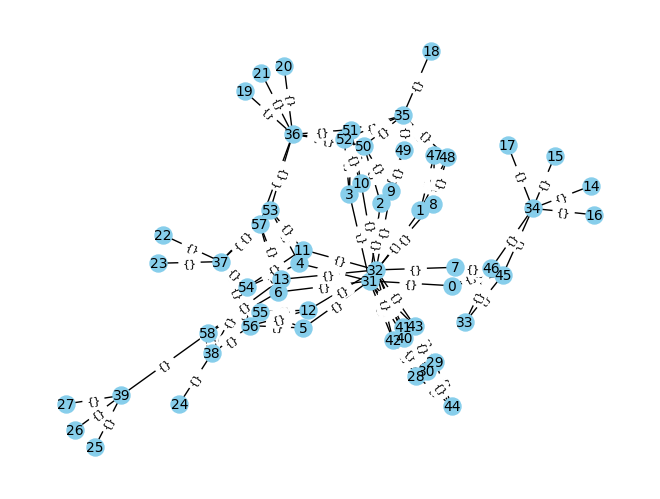

In [8]:
# Create a layout for visualization (e.g., circular layout)
pos = nx.spring_layout(graph)

# Draw nodes with labels and node properties
node_labels = {node_id: f"{node_id}\n{node_data}" for node_id, node_data in graph.nodes(data=True)}
nx.draw(graph, pos, with_labels=True, node_size=150, node_color="skyblue", font_size=10)

# Draw edges with edge properties
edge_labels = {(u, v): data for u, v, data in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

# Display the graph
plt.show()

In [9]:
edges = graph.edges()

# Extract the unique nodes from the edges
nodes = set(node for edge in edges for node in edge)

# Generate all possible node pairs
node_pairs = [(node1, node2) for node1 in component_ids for node2 in machine_state_ids if node1 != node2]

# Assuming you have already created the 'graph' and 'node_pairs' variables
beta = 0.5
predictions = link_prediction(graph, node_pairs, beta)    
    
# Create a mapping of node IDs to their names
node_id_to_name = {node_id: graph.nodes[node_id]['name'] for node_id in graph.nodes()}

# Print the link predictions in descending order with node names
sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
for (node1, node2), score in sorted_predictions:
    node1_name = node_id_to_name[node1]
    node2_name = node_id_to_name[node2]
    print(f"Link Prediction Score for nodes '{node1_name}' and '{node2_name}': {score}")

Link Prediction Score for nodes 'Pump' and 'Normal': 0.0
Link Prediction Score for nodes 'Pump' and 'Imbalance': 0.0
Link Prediction Score for nodes 'Pump' and 'Structural fault': 0.0
Link Prediction Score for nodes 'Pump' and 'Misalignment': 0.0
Link Prediction Score for nodes 'Pump' and 'looseness': 0.0
Link Prediction Score for nodes 'Pump' and 'Bearing Fault': 0.0
Link Prediction Score for nodes 'Pump' and 'Gear Fault': 0.0
Link Prediction Score for nodes 'Fan' and 'Normal': 0.0
Link Prediction Score for nodes 'Fan' and 'Imbalance': 0.0
Link Prediction Score for nodes 'Fan' and 'Structural fault': 0.0
Link Prediction Score for nodes 'Fan' and 'Misalignment': 0.0
Link Prediction Score for nodes 'Fan' and 'looseness': 0.0
Link Prediction Score for nodes 'Fan' and 'Bearing Fault': 0.0
Link Prediction Score for nodes 'Fan' and 'Gear Fault': 0.0
Link Prediction Score for nodes 'Engine' and 'Normal': 0.0
Link Prediction Score for nodes 'Engine' and 'Imbalance': 0.0
Link Prediction Score 

## Katz index

In [10]:
def katz_index(graph, beta=0.1, max_path_length=4):
    katz_scores = {}

    for node1 in component_ids:
        for node2 in machine_state_ids:
            if node1 == node2 or graph.has_edge(node1, node2):
                continue

            # Calculate the common neighbors of node1 and node2
            common_neighbors = set(graph.neighbors(node1)).intersection(graph.neighbors(node2))

            # Calculate the Katz index for the node pair (node1, node2)
            katz_score = 0
            for common_neighbor in common_neighbors:
                for path_length in range(1, max_path_length + 1):
                    katz_score += (beta ** path_length) * nx.shortest_path_length(graph, source=common_neighbor, target=node1) * nx.shortest_path_length(graph, source=common_neighbor, target=node2)

            katz_scores[(node1, node2)] = katz_score

    return katz_scores


# Assuming you already have the 'graph' variable containing your graph data
beta = 0.1
max_path_length = 4
predictions = katz_index(graph, beta, max_path_length)

# Create a mapping of node IDs to their names
node_id_to_name = {node_id: graph.nodes[node_id]['name'] for node_id in graph.nodes()}

# Print the link predictions in descending order with node names
sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
for (node1, node2), score in sorted_predictions:
    node1_name = node_id_to_name[node1]
    node2_name = node_id_to_name[node2]
    print(f"Katz index for link between nodes '{node1_name}' and '{node2_name}': {score}")

Katz index for link between nodes 'Pump' and 'Normal': 0
Katz index for link between nodes 'Pump' and 'Imbalance': 0
Katz index for link between nodes 'Pump' and 'Structural fault': 0
Katz index for link between nodes 'Pump' and 'Misalignment': 0
Katz index for link between nodes 'Pump' and 'looseness': 0
Katz index for link between nodes 'Pump' and 'Bearing Fault': 0
Katz index for link between nodes 'Pump' and 'Gear Fault': 0
Katz index for link between nodes 'Fan' and 'Normal': 0
Katz index for link between nodes 'Fan' and 'Imbalance': 0
Katz index for link between nodes 'Fan' and 'Structural fault': 0
Katz index for link between nodes 'Fan' and 'Misalignment': 0
Katz index for link between nodes 'Fan' and 'looseness': 0
Katz index for link between nodes 'Fan' and 'Bearing Fault': 0
Katz index for link between nodes 'Fan' and 'Gear Fault': 0
Katz index for link between nodes 'Engine' and 'Normal': 0
Katz index for link between nodes 'Engine' and 'Imbalance': 0
Katz index for link be

## Local Path Index

In [11]:
def local_path_index(graph, node_pairs, epsilon, path_length):
    adjacency_matrix = nx.adjacency_matrix(graph).todense()

    # Compute the powers of the adjacency matrix up to path_length
    powers_of_A = [adjacency_matrix]
    for i in range(1, path_length):
        powers_of_A.append(adjacency_matrix.dot(powers_of_A[-1]))

    # Calculate the Local Path Index for each node pair
    predictions = {}
    for node1, node2 in node_pairs:
        lpi = 0
        for i in range(path_length):
            lpi += epsilon**i * powers_of_A[i][node1, node2]
        predictions[(node1, node2)] = lpi

    return predictions

node_pairs = [(node1, node2) for node1 in component_ids for node2 in machine_state_ids if node1 != node2]

epsilon = 0.1
path_length = 5
predictions = local_path_index(graph, node_pairs, epsilon, path_length)

# Print the link predictions in descending order with node names
sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
for (node1, node2), score in sorted_predictions:
    node1_name = node_id_to_name[node1]
    node2_name = node_id_to_name[node2]
    print(f"Katz index for link between nodes '{node1_name}' and '{node2_name}': {score}")

Katz index for link between nodes 'Pump' and 'Structural fault': 0.0048000000000000004
Katz index for link between nodes 'Fan' and 'Structural fault': 0.0048000000000000004
Katz index for link between nodes 'Engine' and 'Structural fault': 0.0048000000000000004
Katz index for link between nodes 'Pump' and 'Misalignment': 0.004000000000000001
Katz index for link between nodes 'Pump' and 'looseness': 0.004000000000000001
Katz index for link between nodes 'Fan' and 'Misalignment': 0.004000000000000001
Katz index for link between nodes 'Fan' and 'looseness': 0.004000000000000001
Katz index for link between nodes 'Engine' and 'Misalignment': 0.004000000000000001
Katz index for link between nodes 'Engine' and 'looseness': 0.004000000000000001
Katz index for link between nodes 'Pump' and 'Bearing Fault': 0.0024000000000000002
Katz index for link between nodes 'Fan' and 'Bearing Fault': 0.0024000000000000002
Katz index for link between nodes 'Engine' and 'Bearing Fault': 0.0024000000000000002


## Classification Using Link Prediction (CULP)

In [11]:
# Algorithm 1: Undirected kNN conversion function
def KNN_CONVERT(X, s, k):
    E = set()
    n = X.shape[0]

    for i in range(n):
        knn_indices = np.argsort(-s[i])[:k]
        for j in knn_indices:
            if i != j:
                E.add((i, j))
                E.add((j, i))  # Since it is undirected

    return E


# Algorithm 2: LEG construction function
def LEG(X_l, X_u, y, s, k):
    X = np.vstack((X_l, X_u))
    n, m = X_l.shape[0], X_u.shape[0]
    C = len(np.unique(y))

    Vl = set(range(1, n + 1))
    Vu = set(range(n + 1, n + m + 1))
    Vc = set(range(n + m + 1, n + m + C + 1))

    Ec = {(i, n + m + y[i]) for i in range(n)}
    Es = KNN_CONVERT(X, s, k)

    V = Vl.union(Vu).union(Vc)
    E = Es.union(Ec)

    return V, E


# Algorithm 3: CULP Algorithm
def CULP(X_l, X_u, y, s, k, lam):
    G_V, G_E = LEG(X_l, X_u, y, s, k)

    n, m = X_l.shape[0], X_u.shape[0]
    y_hat = {}

    for i in range(n + 1, n + m + 1):
        j_star = np.argmax([lam[i, j] for j in range(n + m + 1, n + m + len(np.unique(y)) + 1)])
        y_hat[i] = j_star - (n + m)

    return y_hat
